<a href="https://colab.research.google.com/github/Anshuman33/Nature-Images-Classification/blob/main/IntelImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import plot_model
import zipfile
from datetime import datetime
import os

In [ ]:
# Download the dataset
!gdown https://drive.google.com/uc?id=1ePCpKGc5rZPe3kK7JRWQ9a5_rx_plav2

Downloading...
From: https://drive.google.com/uc?id=1ePCpKGc5rZPe3kK7JRWQ9a5_rx_plav2
To: /content/dataset.zip
363MB [00:07, 49.4MB/s]


In [ ]:
zf = zipfile.ZipFile("dataset.zip")
zf.extractall("dataset/")

In [ ]:
# Parameters
train_path = "dataset/seg_train/seg_train"
test_path = "dataset/seg_test/seg_test"
pred_path = "dataset/seg_pred/"
batch_size = 64
image_dim = (64,64)
shape = list(image_dim) + [3]

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.1,
                                   brightness_range=(0.8,1.0))
train_generator = train_datagen.flow_from_directory(train_path, target_size=image_dim,batch_size=batch_size)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path, target_size=image_dim)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [1]:
# Utility functions
def create_label_dict(class_indices):
    return dict([(v, k) for k, v in class_indices.items()])

def get_label_from_encodings(encodings, label_dict):
    indices = np.argmax(encodings, axis=1)
    labels = np.array(list(map(lambda x: label_dict[x], indices)))
    return labels

def show_images(images, predictions, ground_truth = None, n=32):
    plt.figure(figsize=(20, 10))
    n_rows = int(np.ceil(n/8))
    for i in range(0, n):
        plt.subplot(n_rows, 8, i+1)
        plt.imshow(images[i])
        plt.axis(False)
        title = plt.title(predictions[i])
        if ground_truth is not None:
            if predictions[i] == ground_truth[i]:
                title.set_color("green")
            else:
                title.set_color("red")

In [2]:
# Show some sample images
image_batch, targets = train_generator.next()
label_dict = create_label_dict(train_generator.class_indices)
labels = get_label_from_encodings(targets, label_dict)
show_images(image_batch, labels)

NameError: ignored

In [ ]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(shape))

    x = tf.keras.layers.Conv2D(32, (3,3), activation="relu")(inputs)
    block1_out = tf.keras.layers.MaxPooling2D((2,2))(x)

    
    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same",kernel_regularizer=tf.keras.regularizers.L2(0.008))(block1_out)
    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    block2_out = tf.keras.layers.concatenate([x, block1_out])
    
    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.L2(0.008))(block2_out)
    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    block3_out = tf.keras.layers.concatenate([x, block2_out])

    x = tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.L2(0.008))(block3_out)
    x = tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    block4_out = tf.keras.layers.concatenate([x, block3_out]) 


    x = tf.keras.layers.GlobalAveragePooling2D()(block4_out)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(6, activation="softmax")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=x)
    return model

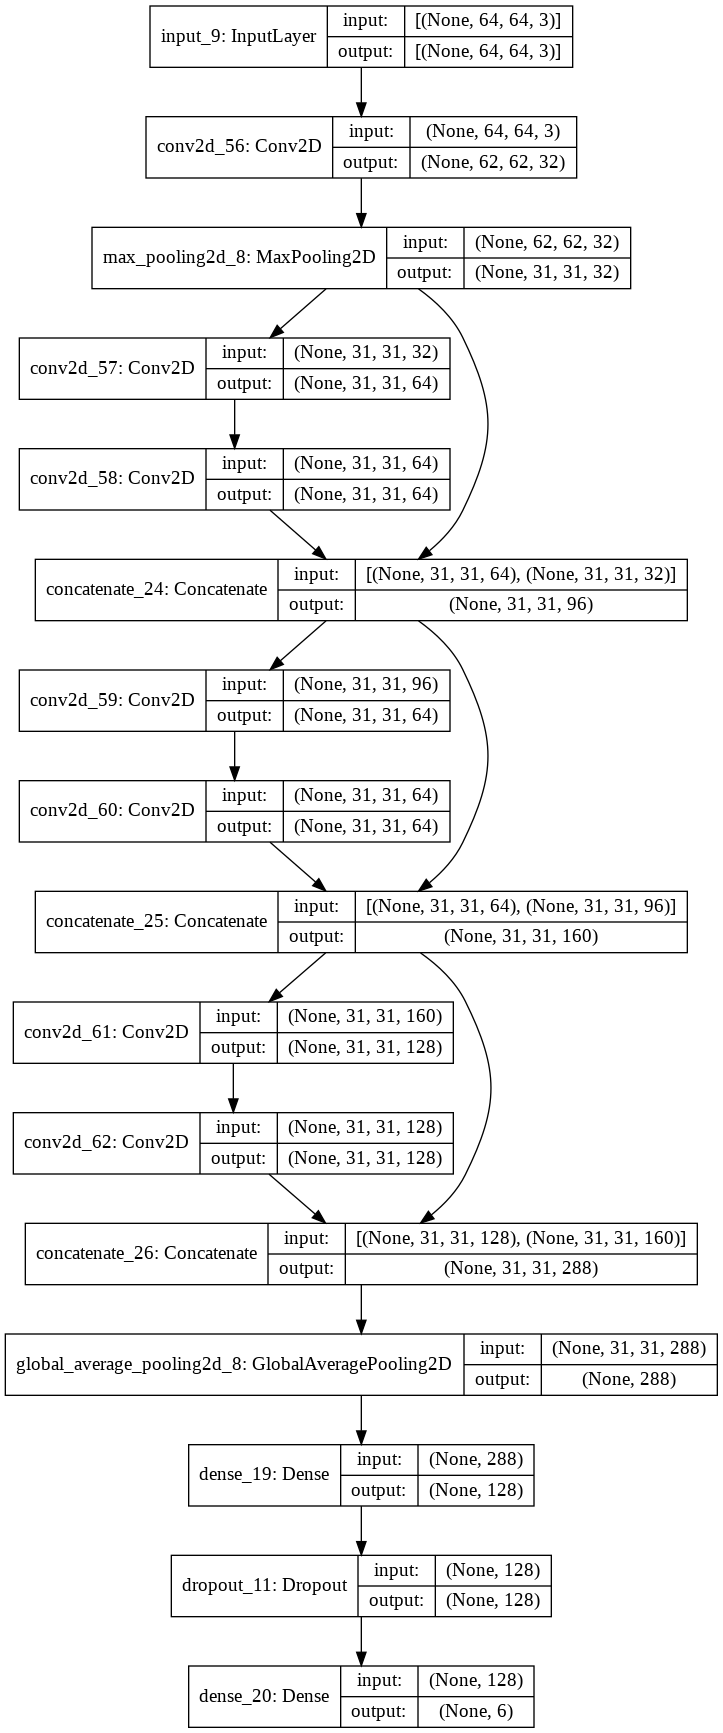

In [ ]:
model = create_model()
plot_model(model, show_shapes=True)

Epoch 1/80
220/220 [==============================] - 60s 137ms/step - loss: 3.4782 - acc: 0.1572 - val_loss: 3.4682 - val_acc: 0.1700
Epoch 2/80
220/220 [==============================] - 29s 132ms/step - loss: 3.4584 - acc: 0.1595 - val_loss: 3.4461 - val_acc: 0.1700
Epoch 3/80
220/220 [==============================] - 29s 134ms/step - loss: 3.4358 - acc: 0.1602 - val_loss: 3.4217 - val_acc: 0.1700
Epoch 4/80
220/220 [==============================] - 30s 135ms/step - loss: 3.4114 - acc: 0.1665 - val_loss: 3.3948 - val_acc: 0.1700
Epoch 5/80
220/220 [==============================] - 30s 135ms/step - loss: 3.3836 - acc: 0.1707 - val_loss: 3.3649 - val_acc: 0.1700
Epoch 6/80
220/220 [==============================] - 30s 135ms/step - loss: 3.3523 - acc: 0.1769 - val_loss: 3.3316 - val_acc: 0.1703
Epoch 7/80
220/220 [==============================] - 30s 135ms/step - loss: 3.3189 - acc: 0.1751 - val_loss: 3.2942 - val_acc: 0.1707
Epoch 8/80
220/220 [==============================] - 3

(1e-07, 1.0)

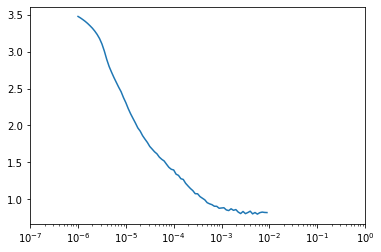

In [ ]:
# Determine the optimum learning rate
INIT_LR = 1e-6
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: INIT_LR * 10**(epoch/20))
lr_model = create_model()
lr_model.compile(optimizer=tf.keras.optimizers.Adam(INIT_LR),loss='categorical_crossentropy',metrics=['acc'])
lr_history = lr_model.fit(
    train_generator,
    batch_size=batch_size,
    validation_data = test_generator,
    epochs=100,
    callbacks = [lr_scheduler],
    verbose=0
)
plt.semilogx(lr_history.history['lr'], lr_history.history['loss'])
plt.xlim(1e-7, 1e0)

In [ ]:
class DetectOverfitting(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        self.threshold = threshold
    def on_epoch_end(self, epoch, logs = None):
        if logs["val_loss"]/logs["loss"] >= self.threshold or logs["val_acc"]>=0.85:
            print("Stopping training")
            self.model.stop_training = True

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_acc",baseline=0.85,patience=1, restore_best_weights=True)
detect_overfitting = DetectOverfitting(threshold=1.5)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='categorical_crossentropy',metrics=['acc'])
train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [ ]:
history = model.fit(
    train_generator,
    batch_size=batch_size,
    validation_data = test_generator,
    epochs=100,
    initial_epoch=0,
    callbacks=[detect_overfitting]
)

Epoch 1/100
220/220 [==============================] - 42s 188ms/step - loss: 1.5982 - acc: 0.4158 - val_loss: 1.2721 - val_acc: 0.4963
Epoch 2/100
220/220 [==============================] - 42s 192ms/step - loss: 1.2221 - acc: 0.5088 - val_loss: 1.1187 - val_acc: 0.5397
Epoch 3/100
220/220 [==============================] - 43s 194ms/step - loss: 1.0987 - acc: 0.5875 - val_loss: 1.1691 - val_acc: 0.5717
Epoch 4/100
220/220 [==============================] - 41s 186ms/step - loss: 1.0222 - acc: 0.6227 - val_loss: 1.0439 - val_acc: 0.5857
Epoch 5/100
220/220 [==============================] - 42s 190ms/step - loss: 0.9783 - acc: 0.6386 - val_loss: 0.9117 - val_acc: 0.6583
Epoch 6/100
220/220 [==============================] - 41s 188ms/step - loss: 0.9663 - acc: 0.6466 - val_loss: 1.0280 - val_acc: 0.6170
Epoch 7/100
220/220 [==============================] - 41s 186ms/step - loss: 0.9206 - acc: 0.6765 - val_loss: 0.8624 - val_acc: 0.7053
Epoch 8/100
220/220 [===========================

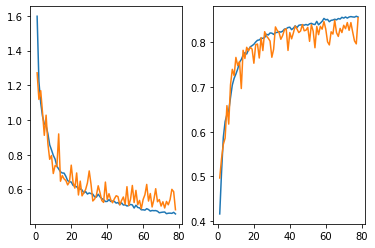

In [ ]:
train_loss += history.history['loss']
train_acc += history.history['acc']
val_loss += history.history['val_loss']
val_acc += history.history['val_acc']
epochs = list(range(1, len(train_loss)+1))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss)
plt.subplot(1,2,2)
plt.plot(epochs, train_acc)
plt.plot(epochs, val_acc)
plt.show()

In [ ]:

now = datetime.now()
current_time = now.strftime("%d:%m_%H:%M")
dirpath = "models/model_{}".format(current_time)
try:
    os.mkdir(dirpath)
except:
    pass
model.save(dirpath + "/model_{}.h5".format(current_time))
plot_model(model, dirpath + "/architecture.png", show_shapes=True, show_layer_names=True)
model.save_weights(dirpath + "/model_weights_{}.h5".format(current_time))

In [ ]:
# Evaluate on test set
model.evaluate(test_generator)

94/94 [==============================] - 3s 33ms/step - loss: 0.5209 - acc: 0.8323


[0.5208920240402222, 0.8323333263397217]

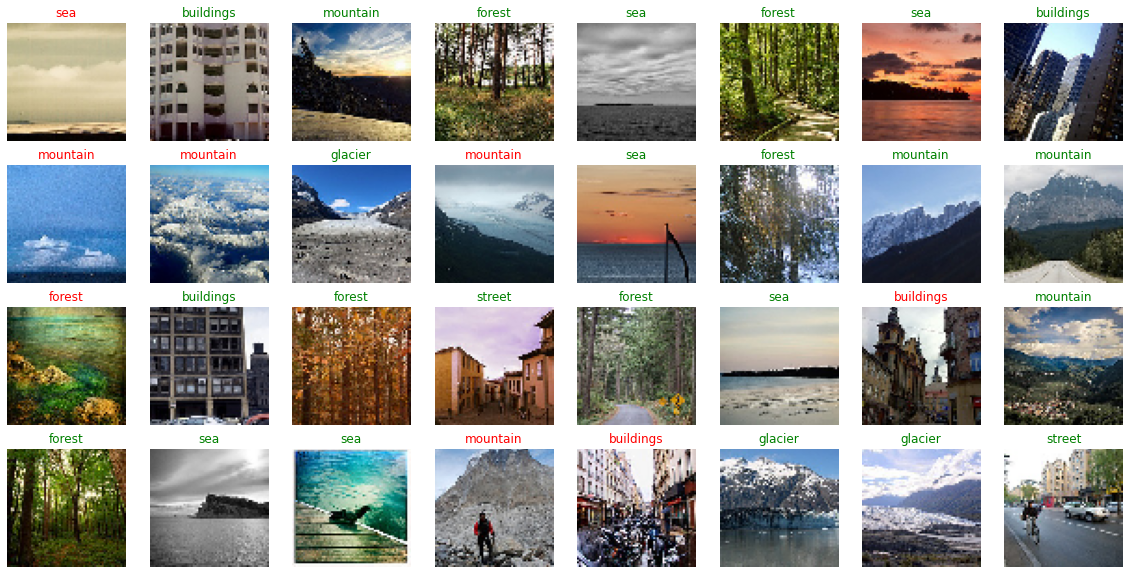

In [ ]:
# Visualize predictions from test set
image_batch, ground_truth = test_generator.next()
predictions = model.predict(test_generator)
ground_truth = get_label_from_encodings(ground_truth, label_dict)
predictions = get_label_from_encodings(predictions, label_dict)
show_images(image_batch, predictions, ground_truth)

Found 7301 images belonging to 1 classes.


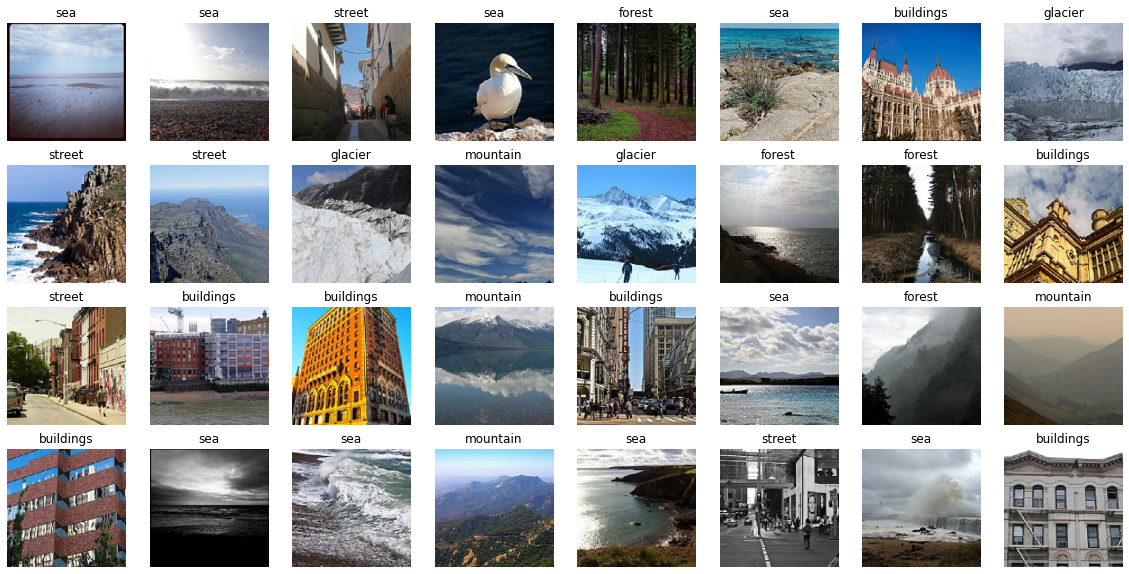

In [ ]:
# Visualize predictions from the pred set
pred_datagen = ImageDataGenerator(rescale=1.0/255.0)
pred_generator = pred_datagen.flow_from_directory(pred_path, class_mode=None,)
image_batch_pred = pred_generator.next()
predictions_pred = model.predict(pred_generator)
predictions_pred = get_label_from_encodings(predictions_pred, label_dict)
show_images(image_batch_pred, predictions_pred)

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
res